In [1]:
from transmission_data import transmission_function
from wigrad import Wiggler, WigglerRadiationSimulator
import numpy as np
import matplotlib.pyplot as plt
from config_ursse import get_from_config

In [2]:
wiggler = Wiggler(K_peak=get_from_config("K_peak"), N_periods=10)
x_max = 0.007257142857142857
y_max = x_max/np.sqrt(2)
n_x = int(512/4)
n_y = int(n_x/np.sqrt(2))
n_l = int(300/4)
l_min = 0.4
l_max = 0.9
x_step = x_max/(n_x-1/2)
y_step = y_max/(n_y-1/2)
l_step = (l_max-l_min)/(n_l-1)
mesh = (np.linspace(x_step/2, x_max, n_x),
        np.linspace(y_step/2, y_max, n_y),
        np.linspace(l_min, l_max, n_l))
spectral_transmission = transmission_function(mesh[2])
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=get_from_config("gamma"),
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
    only_calc_sum_of_both_polarizations=False,  # if False, then both polarizations are calculated separately
    spectral_transmission=spectral_transmission
    )

In [3]:
wr_sim.calc_photon_flux_on_meshgrid()

In [4]:
wr_sim.extend_results_using_symmetries()

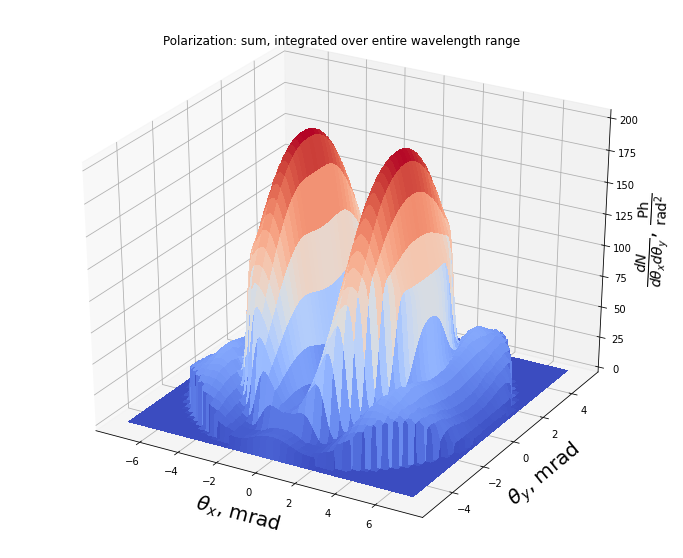

In [5]:
wr_sim.show_angular_distribution()

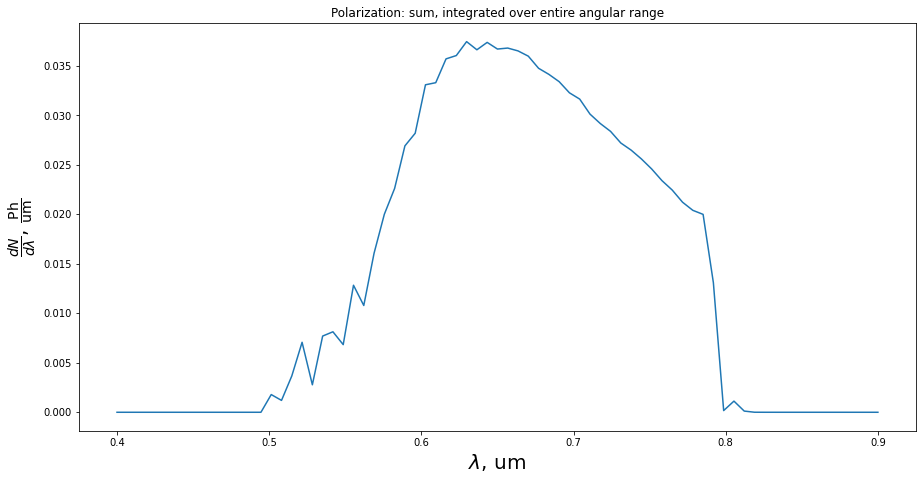

In [6]:
wr_sim.show_spectral_distribution()

In [7]:
wr_sim.get_total_photon_flux()*7.5e6

53326.313963408524